In [4]:
import os, sys
import imageio
import numpy as np
from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split 
from torchvision import transforms
from torchsummary import summary
from shutil import copyfile

# generate face bounding box
import glob
import dlib
from imutils import face_utils, resize
from copy import copy
from pathlib import Path

import xml.etree.cElementTree as ET
import random


In [5]:
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Please make sure this notebook is running with /src as direct child directory

    Testing.ipynb
    /src
       /helper
      /xception
      train.py
      
Also please provide path for the following:

`data_dir`: absolute path to the training data set. Inside this path, please make sure:

    /Landmark Dataset
        /ibug_300W_large_face_landmark_dataset
        /dataset_5000
        labels_ms_synthesis_dlib.xml
        labels_ms_synthesis_landmark.xml
        labels_ms_synthesis_mix.xml
        labels_ibug_300W_train.xml

The `xml` files can be found in this repo. The `/dataset_5000` is the directory made by copying 5000 images randomly from the Microsoft Synthesis data (the `.png` and `.txt` landmark labels). The `ibug_300W_large_face_landmark_dataset` is downloaded directly from `http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz` (more information found on https://github.com/braindotai/Facial-Landmarks-Detection-Pytorch. 

You can also create these `xml` by running `/helper/build_synthesis_xml.py`.

# Step1: Prep
1. load necessary components from /src
2. define some useful functions

Some useful definitions:

locations: a list of training sets: `[["path_to_training dir", "title for this training set"]]`

In [6]:
from helper.dataGenerater import loadXML
from xception.xception import LandmarksAugmentation, FaceAugmentation, Preprocessor, XceptionNet
from helper.build_synthesis_xml import bbox_from_dlib, bbox_from_ldmks

In [136]:
# plot single loss vs. epoch on ax
def loss_plot(ax, train_losses, val_losses, title):
    ax.plot(range(1, len(val_losses)+1), train_losses, label="train loss")
    ax.plot(range(1, len(val_losses)+1), val_losses, label="val loss")
    ax.set_xlabel('epochs')
    ax.set_ylabel('losses')
    ax.legend()
    ax.set_title(title)

# Plot loss function for all training sets.
def plotLosses(locations, size = 8, shape=(2, 2), padding=0.3):    
    fig, axs = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=(size, size))
    fig.tight_layout()
    fig.subplots_adjust(hspace=padding, wspace=padding)
    
    for ax, location in zip([l for sublist in axs for l in sublist ], locations):
        filename = location[0]
        title = location[1]
        epoch_data = []
        with open(filename, 'r') as f:
            epoch_data = f.readlines()
        train_losses = []
        val_losses = []
        for line in epoch_data:
            if not line.strip():
                continue
            train_losses.append(float(line.split("|")[0].split(":")[-1]))
            val_losses.append(float(line.split("|")[1].split(":")[-1]))            
        loss_plot(ax, train_losses, val_losses, title)
    plt.show()

In [142]:
# check completed epochs for training sets
def check_epoch_completion(locations):
    for d in locations:
        with open(d[0], "r") as f:
            print(f"{d[0].split('/')[-2]}: {f.readlines()[-1].split('->')[0]}")

In [138]:
# shared configuration used in each training for image preprocessing
config = {
    "data_dir": "/irrelevent/path/here",
    "bbox_option": "mix", # modify for each training set
    "size": "1000", # modify for each training set
    "ft_ratio": "0.8", # modify for each training set
    "train_test_split": "1.0",
    "image_dim": "128",
    "brightness": "0.24",
    "saturation": "0.3",
    "contrast": "0.15",
    "hue": "0.14",
    "angle": "14",
    "face_offset": "32",
    "crop_offset": "16",
    "batch_size": "32",
    "epochs": "60" # modify for each training set
}

In [79]:
# Create preprocessor for modifying testing images 
preprocessor = Preprocessor(
    image_dim = int(config["image_dim"]),
    brightness = float(config["brightness"]),
    saturation = float(config["saturation"]),
    contrast = float(config["contrast"]),
    hue = float(config["hue"]),
    angle = int(config["angle"]),
    face_offset = int(config["face_offset"]),
    crop_offset = int(config["crop_offset"]))

In [139]:
# Image XML Loading
data_dir = "/absolute/path/to/training/data" # see comments in the beginning
ibug_label = "labels_ibug_300W_train.xml"
dlib_label = "labels_ms_synthesis_dlib.xml"
ldmk_label = "labels_ms_synthesis_landmark.xml"
mix_label = "labels_ms_synthesis_mix.xml"
test_label = "labels_ibug_300W_test.xml"

In [140]:
# Result Loading
#       --     path to directory containing training result
result_dir = '/Users/dongxuhuang/MEGA/SFU/732/Final Project/landmark_detection/src'

# Inside this path, you should have subfolders with
#    /subfolder (e.g. t2000_06)
#          model.epoch
#          model.pt
#          data_list.pickle

locations = [
    ["t2000_06/model.epoch", "2000 0.6"],
    ["t2000_08/model.epoch", "2000 0.8"],
    ["t2000_10/model.epoch", "2000 1.0"],
    ["t3000_06/model.epoch", "3000 0.6"],
    ["t3000_08/model.epoch", "3000 0.8"],
    ["t3000_10/model.epoch", "3000 1.0"],
    ["t4000_06/model.epoch", "4000 0.6"],
    ["t4000_08/model.epoch", "4000 0.8"],
    ["t4000_10/model.epoch", "4000 1.0"]
]

for _ in locations: # make path absolute
    _[0] = os.path.join(result_dir, _[0])

In [13]:
# Load XML

# [{"file": "/absolute/path/to/image.{pngjpg}", "box": (x, y, w, h) -> int, "landmarks": 68*[(x, y)]} -> int]
ibug_data = loadXML(ibug_label, data_dir, limit=100) # ibug 300W real face data, 6666 images
mix_data = loadXML(mix_label, data_dir, limit=100) # ms synthesis face, bbox generated by dlib and landmarks, 5000
dlib_data = loadXML(dlib_label, data_dir, limit=100) # ms synthesis face, bbox generated only by dlib, 2855
test_data = loadXML(test_label, data_dir, limit=300) # ms synthesis face, bbox generated only by landmark, 5000

# Step 2: Check training convergence

In [143]:
check_epoch_completion(locations)

t2000_06: Epoch(43/100) 
t2000_08: Epoch(34/100) 
t2000_10: Epoch(31/100) 
t3000_06: Epoch(31/100) 
t3000_08: Epoch(100/100) 
t3000_10: Epoch(21/100) 
t4000_06: Epoch(17/100) 
t4000_08: Epoch(26/100) 
t4000_10: Epoch(29/100) 


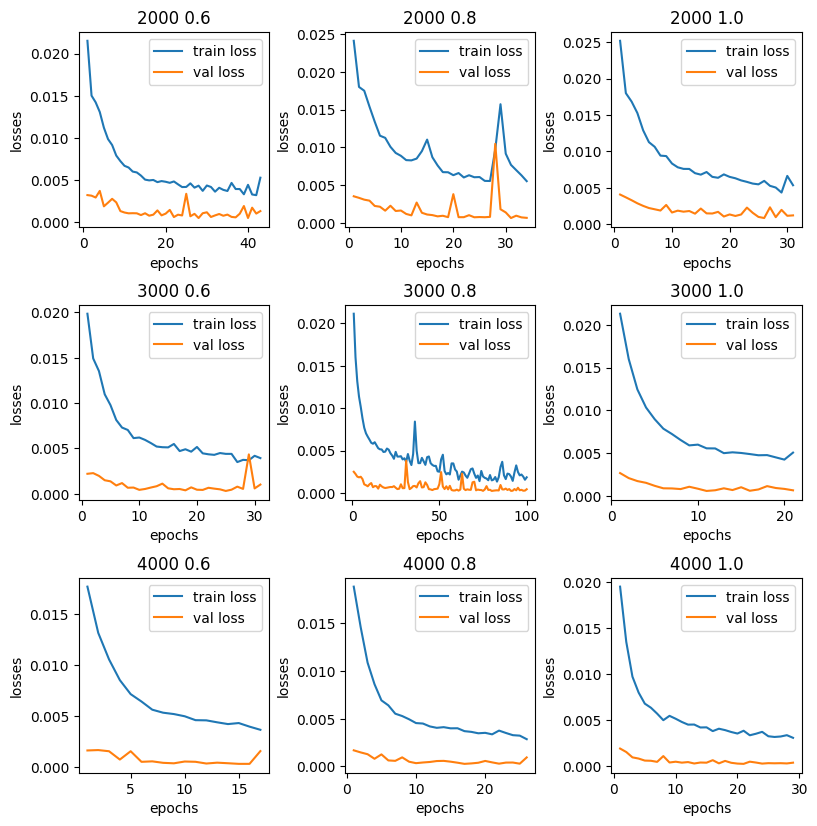

In [75]:
plotLosses(locations, size = 8, shape=(3, 3), padding=0.4) 

# Step 3: Visualize pretrain images

In [144]:
def visualize_pytorch_image(image, landmarks, image_dim=128):
    'draw a 128x128 image with preprocessor processed landmarks'
    plt.figure(figsize = (5, 5)) # image size: 128
    # normalize color values
    image = (image - image.min())/(image.max() - image.min())
    # restore landmark to image size
    landmarks = landmarks.view(-1, 2)
    landmarks = (landmarks + 0.5) * image_dim # restore landmarks to 128x128
    # draw image and landmarks
    plt.imshow(image[0], cmap = 'gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 25, c = 'dodgerblue')
    plt.axis('off')
    plt.show()

def visualize_pretrain(data_batch, index):
    image = io.imread(data_batch[index]['file'])
    landmarks = np.array(data_batch[index]['landmarks']).astype('float32')
    crops = data_batch[index]['box']
    crops = {'left': crops[0], 'top': crops[1], 'width': crops[2], 'height': crops[3]}
    
    image, landmarks = preprocessor(image, landmarks, crops)
    visualize_pytorch_image(image, landmarks)

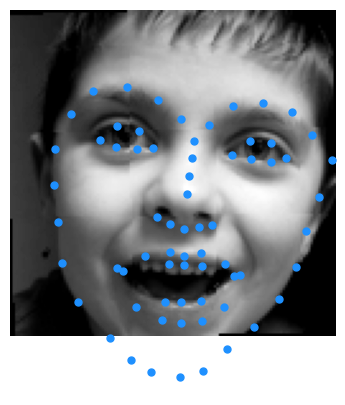

In [145]:
# visualize ibug_data training dataset 
visualize_pretrain(ibug_data, 2)

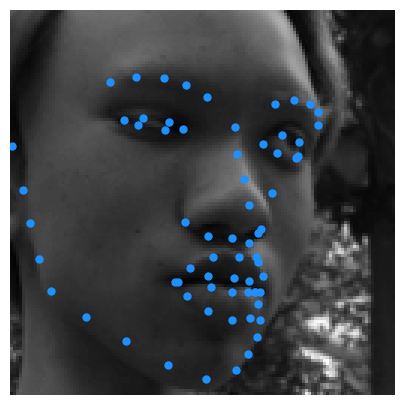

In [81]:
# visualize synthesis training dataset (mixed bbox methods)
visualize_pretrain(mix_data, 2)

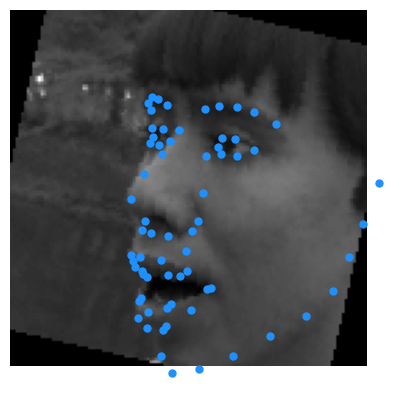

In [784]:
# visualize synthesis training dataset (dlib bbox only)
visualize_pretrain(dlib_data, 2)

# Step 3: Testing trained model

In [146]:
print(f'there are {len(test_data)} test images.')

there are 300 test images.


In [149]:
# load model checkpoint file
def loadModelState(epoch_filename):
    model_pt = epoch_filename.replace('.epoch', '.pt')
    model = XceptionNet()
    model.load_state_dict(torch.load(model_pt, map_location = 'cpu'))
    return model

# scale and normalize image to evaluate
def preprocess_image(image):
    image = TF.to_pil_image(image)
    image = TF.resize(image, (128, 128))
    image = TF.to_tensor(image)
    image = (image - image.min())/(image.max() - image.min())
    image = (2 * image) - 1
    return image.unsqueeze(0)

@torch.no_grad()
def visualize_image(image, model, faces=[], labels=[]):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    outputs = []
    for face in faces:
        (x, y, w, h) = face
        crop_img = gray[y: y + h, x: x + w]
        preprocessed_image = preprocess_image(crop_img)
        if torch.cuda.is_available():
            preprocessed_image = preprocessed_image.cuda()
        # evaluate model
        predicted = model(preprocessed_image)
        outputs.append((predicted.cpu(), (x, y, h, w)))
        
    labels[:, 0] *= int(128/w)
    labels[:, 1] *= int(128/h)
    labels = labels.numpy()
        
    image = image.copy()
    xmin, ymin, xmax, ymax = 512, 512, 0, 0
    for landmarks, (left, top, height, width) in outputs:
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5)
        landmarks = landmarks.numpy()
        
        squared_loss = ((landmarks[:, 0] - labels[:, 0])**2 + (landmarks[:, 1] - labels[:, 1])**2).sum()
        
        for i, (x, y) in enumerate(landmarks, 1):
            try:
                cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 5, [40, 117, 255], -1)
                xmin = min(int((x * width) + left), xmin)
                xmax = max(int((x * width) + left), xmax)
                ymin = min(int((y * height) + top), ymin)
                ymax = max(int((y * height) + top), ymax)
            except:
                pass
#     image = image[xmin-15:xmax+15, ymin-15:ymax+15]
    return image, squared_loss

In [148]:
# plot inference results for all testing sets
def plotInferences(locations, test_data, size = 8, shape=(2, 2), padding=0.3):    
    fig, axs = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=(size, size))
    fig.tight_layout()
    fig.subplots_adjust(hspace=padding, wspace=padding)
    
    for ax, location in zip([l for sublist in axs for l in sublist ], locations):
        model = loadModelState(location[0])
        _image = io.imread(test_data['file'])
        _crops = test_data['box']
        _landmarks = torch.tensor(test_data['landmarks'])
        image, squared_loss = visualize_image(_image, model, [_crops], _landmarks)
        
        ax.imshow(image)
        ax.set_title(location[1] + ", " + "loss={:.2f}".format(float(squared_loss)))
        ax.axis('off')
    plt.show()

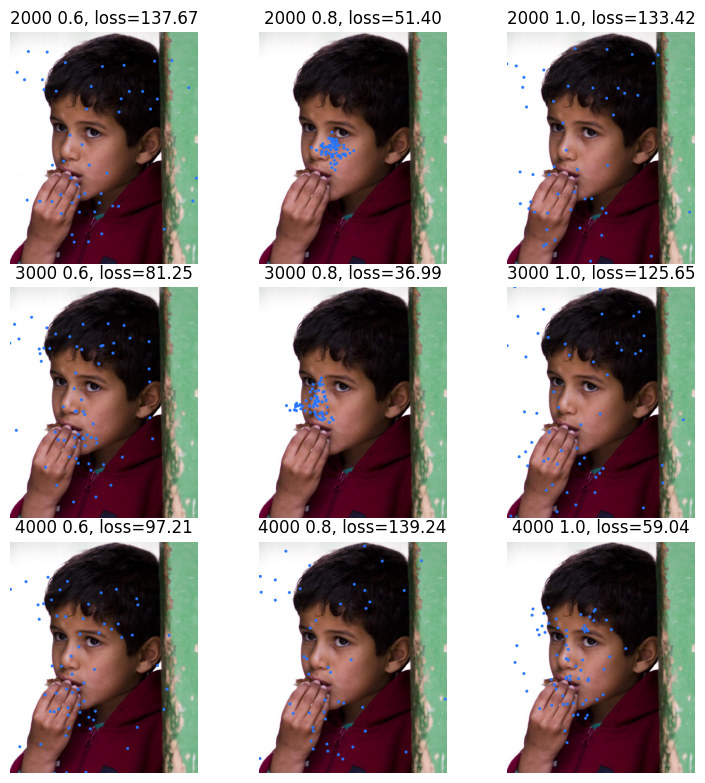

In [131]:
plotInferences(locations, test_data[1], size=8, shape=(3, 3), padding=0.1)

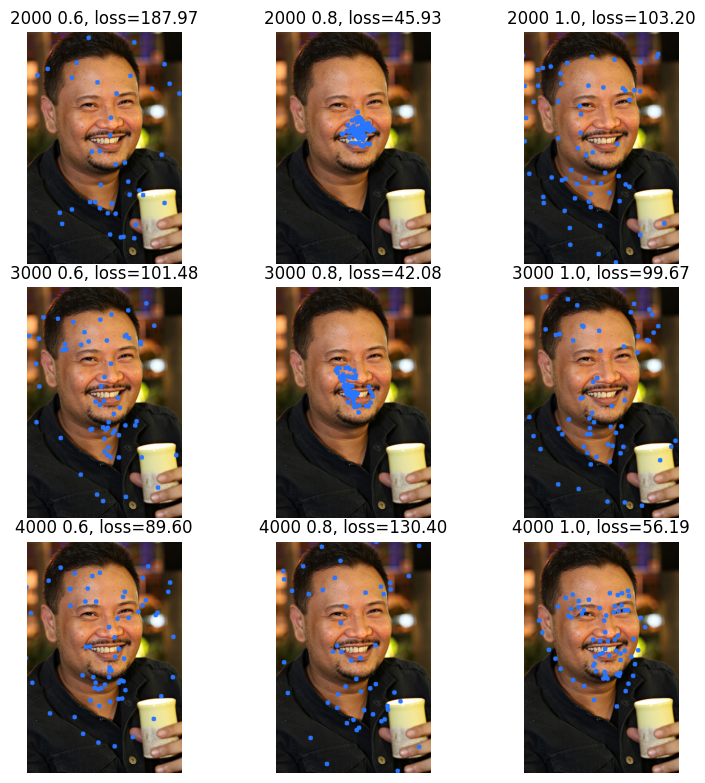

In [132]:
plotInferences(locations, test_data[100], size=8, shape=(3, 3), padding=0.1)

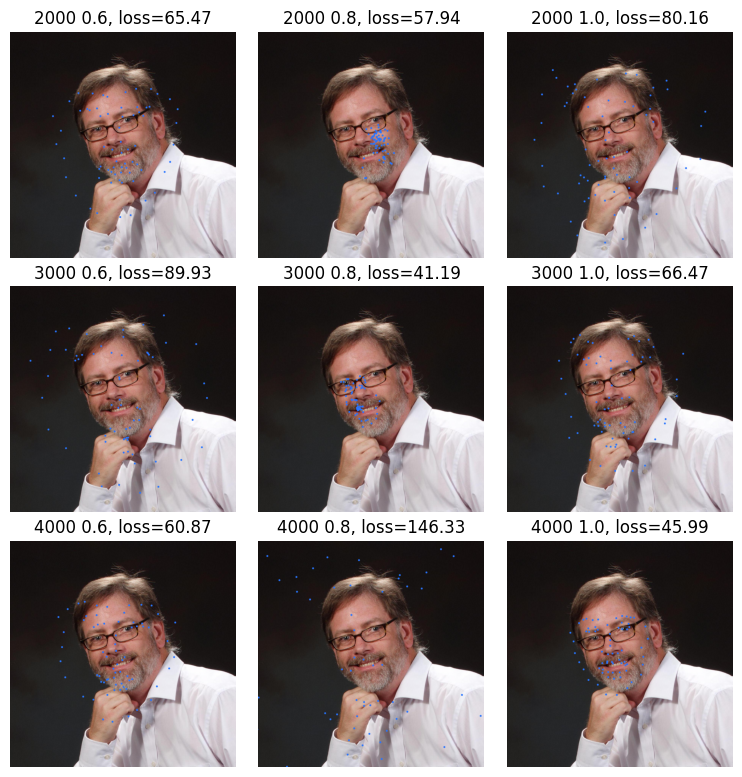

In [133]:
plotInferences(locations, test_data[-237], size=8, shape=(3, 3), padding=0.1)

# SOME NOTES #


#########################################
########### required file system #######
#######################################
## Source Code 
## /train.py ###########################
##     /train_set1 ####################
##          train.json ###############
##          model.epoch #############
##          model.pt ###############
##          traindata.pickle ######
##      /trian_set2 #################
##      /trian_set3 #################
#######################################
# run: python3 train.py --file train_set1 --resume (optional)
#######################################
#  train.json: training and model parameters
#  model.pt: checkpoint file
#  model.epoch: tracking text file
#  traindata.pickle: pickle for generated traindata list
#######################################
#######################################
## Data storage
## /mydata
##      /ibug_300W_large_face_landmark_dataset <-- 300W real face dataset
##      /dataset_5000 <-- MS Synthesis dataset
##      labels_ibug_300W_train.xml
##      labels_ms_synthesis_dlib.xml
##      labels_ms_synthesis_landmark.xml
##      labels_ms_synthesis_mix.xml
#######################################

#######################################
######## Evaluation ###################
## Please use eval.ipynb notebook ####
######################################

######################################
######################################
## Example train.json
# {
#     "data_dir": "/absolute/path/project/dataset", <-- point to dataset folder
#     "bbox_option": "mix",  <-- choose how bbox is created for ms_synthesis_dataset
#                                (dlib: by dlib library, landmark: use ranges of landmark labels, 
#                                   mixed: use dlib when possible, then landmark)
#     "size": "2000",       <-- size of training dataset (inlcuding validation)
#     "ft_ratio": "0.8",      <-- ratio of synthesis-2-real images used in training set
#     "train_test_split": "1.0",    <-- train test split, should be 1.0. Testing is not included in this script

#     "image_dim": "128",       <-- Preprocessing parameters: please check original github project
#     "brightness": "0.24",
#     "saturation": "0.3",
#     "contrast": "0.15",
#     "hue": "0.14",
#     "angle": "14",
#     "face_offset": "32",
#     "crop_offset": "16",
#     "batch_size": "32",

#     "epochs": "80"        <-- number of training epochs
# }
######################################
######################################